# Music Recommendation System with Mathematical Optimization

In this notebook, we will walk-through how to create a music recommendation system using a mixture of predictive and prescriptive analytics. The predictive component foresees what users might be into based on their past music preferences, while the prescriptive component uses these predictions to create an optimally diverse recommendation list.

## Load the data

In [1]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df_artist = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/music_recommendation/artist_data.csv')
print(len(df_artist),'artists')
df_artist.head()

8465 artists


,artist_id,artist,country,listeners
0,0,Coldplay,United Kingdom,5381567
1,1,Radiohead,United Kingdom,4732528
2,2,Red Hot Chili Peppers,United States,4620835
3,3,Rihanna,United States,4558193
4,4,Eminem,United States,4517997


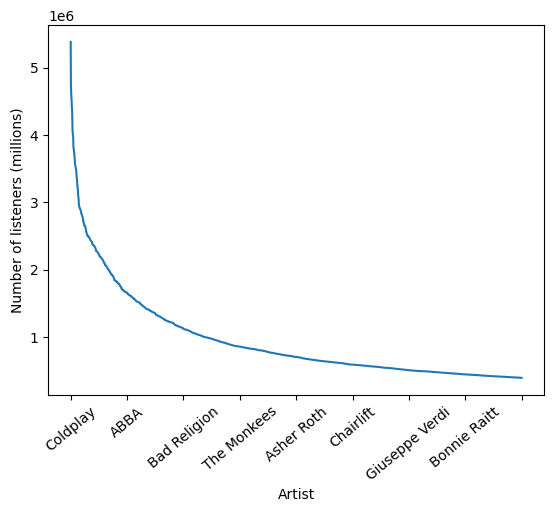

In [5]:
df_artist.set_index('artist')['listeners'].head(2000).plot(rot=40)
plt.xlabel('Artist')
plt.ylabel('Number of listeners (millions)')
plt.show()

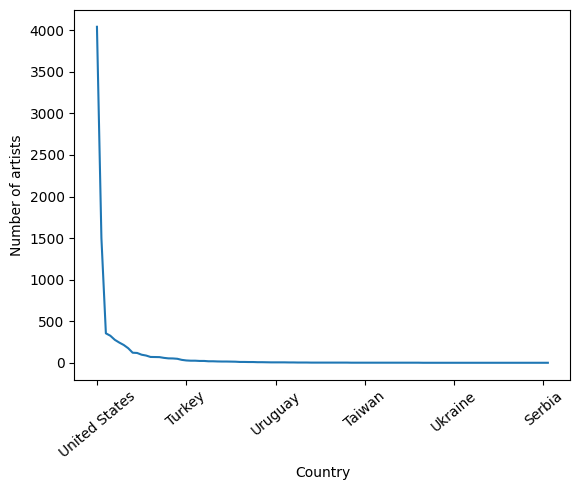

In [6]:
df_country = df_artist.groupby('country')['country'].count().sort_values(ascending=False).reset_index(name='count')
df_country.set_index('country')['count'].head(2000).plot(rot=40)
plt.xlabel('Country')
plt.ylabel('Number of artists')
plt.show()

Next we load the dataset with user information on playlists created by each of the 1360 users. 

In [7]:
df_playlist = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/music_recommendation/user_playlist_data.csv')
print(df_playlist['user_id'].nunique(),"users") 
df_playlist.head(50) 

1306 users


,user_id,artist_id,artist,track,playlist
0,785,622,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,785,622,Elvis Costello,Alison,HARD ROCK 2010
2,785,622,Elvis Costello,Tramp The Dirt Down,HARD ROCK 2010
3,993,622,Elvis Costello,Don't Let Me Be Misunderstood,Everything at once
4,487,622,Elvis Costello,Alison,Home
5,300,622,Elvis Costello,Beautiful,Ángeles
6,155,622,Elvis Costello,Watching The Detectives - Single Version,Vergaarbaak
7,155,622,Elvis Costello,She,Voorbeschouwing
8,317,622,Elvis Costello,Deep Dark Truthful Mirror,We Are Hunted Paramore Chart Jan 12
9,697,622,Elvis Costello,Alison,All Time Great Songs


## Train the predicion model using collaborative filtering:

Now train a prediction model to learn the users' preferences of artists using collaborative filtering, a popular method commonly used for product recommendations. The idea is to user the collaborative information of all other users to predict the preference of one user. 

To achieve collaborative filtering on this user-artist dataset, will use matrix factorization. Here, the key input is an  n×m  matrix with rows comprising  n  users and columns comprising  m  artists. An entry in the matrix denotes how much that user likes that artist- measured by the frequency of artist occurrence in their playlists. This matrix is factorized into two matrices with dimensions  n×d  and  d×m , where  d  is the number of hidden features. The larger the number of features  d , the more complex and nuanced the model is, albeit running the risk of over-fitting. See [here](https://github.com/lyst/lightfm) to read more about collaborative filtering.

We will use [lightfm](vhttps://github.com/lyst/lightfm) for matrix factorization as follows.

In [8]:
# Dataframe that stores the frequency of artists as they appear in user's playlists
df_freq = df_playlist.groupby(['user_id','artist']).agg('size').reset_index().rename(columns={0:'freq'})[['user_id','artist','freq']].sort_values(['freq'],ascending=False)
df_freq = df_freq.merge(df_artist[['artist','artist_id']],left_on='artist',right_on='artist')

#Input matrix:
input_matrix = df_freq.groupby(['user_id','artist_id'])['freq'].sum().unstack().reset_index().fillna(0).set_index('user_id')

# Dictionary to track the artist id for each artist name:

artist_dict = {(df_artist.loc[i,'artist_id']): df_artist.loc[i,'artist'] for i in range(df_artist.shape[0])}

Before training the prediction model, the dataset is randomly split into a training set (80%) and a testing set (20%) to evaluate the fit. The quality of the fit is measured by the area under an ROC curve (AUC) metric. 

In [14]:
import lightfm 
from lightfm import LightFM, cross_validation
from lightfm.evaluation import auc_score  

In [15]:
from scipy import sparse

x = sparse.csr_matrix(input_matrix.values)
train, test = lightfm.cross_validation.random_train_test_split(x, test_percentage=0.2, random_state=None)

# Train the Matrix Factorization Model

model = LightFM(no_components=50,loss='warp')
model.fit(x, epochs=30, num_threads=4)

train_auc = auc_score(model, train, num_threads=4).mean()
test_auc = auc_score(model, test, train_interactions=train,num_threads=4).mean()
print(f'Train AUC: {train_auc}, Test AUC: {test_auc}')

Train AUC: 0.9839404821395874, Test AUC: 0.9857179522514343


## Recommendations

### Select a User:

The prediction model has been trained. For the rest of the notebook, we focus on recommending artists for one user. First, select a user and retrieve their learned preference scores (a value between 0 and 1) among the artists. The higher the preference score, the greater their preference for that user according to the trained model.

To select a user, use the dropdown at the bottom of this cell to choose a user id from 0 (default) through 1,305.

In [20]:
from __future__ import print_function
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

def get_user_preference(x):
    # Create dict that stores the preference for each artist as a number betweeen 0 and 1
    global preference, df_pref
    preference = pd.Series(model.predict(x, np.arange(input_matrix.shape[1]))).to_dict()
    lower_score = min(preference.values())
    highest_score = max(preference.values())
    preference = {artist_dict[i]: (preference[i]-lower_score)/(highest_score-lower_score) for i in preference}
    
    # Print the known likes of the user:
    known_items = list(pd.Series(input_matrix.loc[x,:][input_matrix.loc[x,:]>0].index).sort_values(ascending=False))
    known_items = list(pd.Series(known_items).apply(lambda x: artist_dict[x]))
    print("Top 20 artists this user already likes: \n", known_items[:20])
    
    #Print the predicted preference scorre of the user:
    df_pref = pd.DataFrame.from_records([(k,v) for k, v in preference.items()],columns=['artist','preference'])
    df_pref = df_artist.merge(df_pref,left_on='artist',right_on='artist').sort_values(by='preference',ascending=False)
    print('\nPredicted preferences:')

In [21]:
n_users = df_playlist['user_id'].nunique()
print('Select a user id from 0 through %i.'%(n_users-1))
interact(get_user_preference, x=list(range(n_users)))
df_pref.head(30)

Select a user id from 0 through 1305.


interactive(children=(Dropdown(description='x', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

,artist_id,artist,country,listeners,preference
3,3,Rihanna,United States,4558193,1.000000
90,90,Kelly Clarkson,United States,2425837,0.993308
30,30,Britney Spears,United States,3255085,0.981620
52,52,Christina Aguilera,United States,2788515,0.977535
62,62,Usher,United States,2650020,0.975282
85,85,Mariah Carey,United States,2459108,0.974436
78,78,P!nk,United States,2495211,0.960323
342,342,Backstreet Boys,United States,1413894,0.958230
322,322,R. Kelly,United States,1456472,0.954337
109,109,Alicia Keys,United States,2325048,0.953474


For our chosen user, we have the predicted preference scores for the artists. Looking at the most preferred artists, several of the artists are massively popular. For example, for user 0, their 30 most preferred artists have more than a million listeners on average.

In [22]:
print("The top 30 artists have %i listeners on average."% int(df_pref[['listeners']].head(30).sum()/30))

The top 30 artists have 2587299 listeners on average.


### Optimize for popularity diversity

But what if we want to recommend less popular artists? Adding niche artists to the basket of recommended artists could improve the novelty of the recommendation, while also supporting newer artists.

We now introduce a mathematical optimization model to optimally resolve this trade-off between preference and popularity. An optimization model seeks to find the best solution according to an objective function such that the solution satisfies a pre-defined set of constraints. Here, a solution is expressed as a vector of real values or integer (e.g., binary) values called decision variables. Constraints are a set of equations or inequalities written as a function of the decision variables.

For our model, a solution is given by the chosen set of artists. The objective function is to maximize the total preference scores among the chosen artists so that the recommended artists are likable. In order to control the overall popularity of the chosen artists, we enforce a constraint that the average popularity is less than a pre-defined maximum limit. We also add a constraint that the number of artists are fixed to a pre-defined value. Hence, this is an optimization model that maximizes preference with constraints on popularity and size.

Let us now define some input parameters and notations used for creating the model. The subscript  a  will be used to denote individual artists across the set of all artists we can choose from. The set of artists. preference and popularity are derived from the datasets.

#### Input parameters:

**$p_{a}$** : the user's preference for an artist  a ,

**$q_{a}$** : popularity of artist  a  measured by their number of listeners,

**N** : number of artists to choose,

**Pmax** : maximum limit on the average popularity among chosen set of artists.

The following code loads the Gurobi python package and initiates the optimization model. The values of  N  and  Pmax  can be altered in the below cell. For illustration, the maximum popularity limit is set to  500,000  listeners, and the number of artists is set to  30 .

In [23]:
import gurobipy as gp
from gurobipy import GRB

artists = sorted(preference.keys(),reverse=True,key=lambda x: preference[x])[:1000]
popularity = df_artist.groupby('artist')['listeners'].apply(float).to_dict()
P_max = 500000
N = 30

m = gp.Model('Recommend artists')

Restricted license - for non-production use only - expires 2023-10-25


#### Decision Variables:

The key data structure that stores the solution of an optimization problem is a decision variable. In our model, we want to store whether or not an artist is chosen to be included in the solution. Hence, we define the following binary decision variable for each artist  a  to represent a yes or no decision we want to make. This is modeled as  xa=1  if artist  a  is chosen; and  xa=0  otherwise.

Dictionaries are a good way to store the decision variables. We can add the variables either by looping through each artist, or all at once (as shown in the commented code below).

In [24]:
x = {}
for a in artists:
    x[a] = m.addVar(vtype=GRB.BINARY) 

#### Objective

Next we will define the objective function: we want to maximize the total preference of the choosen artists. Using the binary decision variables, the objective can be written as follows:

$$ maximize \sum_{a} p_{a}x_{a} $$

In [25]:
m.setObjective(sum(x[a]*preference[a] for a in artists), GRB.MAXIMIZE)
m.ModelSense = GRB.MAXIMIZE

#### Popularity Constraint

We want to make sure that the average popularity of the chosen artist is less than pre-defined value **$P_{max}$**. This condition is expressed as a constraint written as follows:

$$ \sum_{a} q_{a}x_{a} <= P_{max} $$

In [26]:
popularity_constraints = m.addConstr(sum(x[a]*popularity[a] for a in artists) <= P_max*N)

#### Size Constraint

Finally, we want to select exactly  N  number of artists. This condition is expressed as the following constraint.

$$ \sum_{a} x_{a} = N $$

In [27]:
n_artists_constraints = m.addConstr(sum(x[a] for a in artists) == N)

Finally, once all the constraints are added, we can tell Gurobi to solve the optimization model and find the optimal solution.

In [28]:
m.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 2 rows, 1000 columns and 2000 nonzeros
Model fingerprint: 0x6cdddff3
Variable types: 0 continuous, 1000 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+06]
  Objective range  [6e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+01, 2e+07]
Presolve time: 0.02s
Presolved: 2 rows, 1000 columns, 2000 nonzeros
Variable types: 0 continuous, 1000 integer (1000 binary)
Found heuristic solution: objective 22.2713281

Root relaxation: objective 2.516982e+01, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   25.16982    0    2   22.27133   25.16982  13.0%     -    0s
H    0     0                      25.1553359   25.16982  0.06%     -    0

The optimizer solved the model. Let us now retrieve the optimal solution. The value of variable  xa  can be retrieved using the code "x[a].X"; artist  a  is chosen if x[a].X is  1 .

The following code stores the solution as a Pandas dataframe.

In [29]:
chosen_artists = [a for a in artists if x[a].X > .99]  
dict_artist_country = dict(zip(df_artist.artist, df_artist.country))

df_chosen_artists = pd.DataFrame({'artists':chosen_artists, 'popularity':[popularity[i] for i in chosen_artists], 'preference':[preference[i] for i in chosen_artists], 'country':[dict_artist_country[i] for i in chosen_artists]})
print("Artists chosen:"%(chosen_artists))
df_chosen_artists

Artists chosen:


,artists,popularity,preference,country
0,Backstreet Boys,1413894.0,0.958230,United States
1,R. Kelly,1456472.0,0.954337,United States
2,Céline Dion,1376413.0,0.950273,Canada
3,Shania Twain,949638.0,0.906305,Canada
4,Westlife,625166.0,0.906134,Ireland
5,Savage Garden,916122.0,0.891713,Australia
6,Girls Aloud,723845.0,0.887001,United Kingdom
7,Take That,830652.0,0.878217,United Kingdom
8,Jennifer Hudson,613389.0,0.868961,United States
9,Luther Vandross,700090.0,0.867912,United States


While this recommendation is diverse in terms of popularity, the artists are predominantly from a set of few countries. Can international diversity be infused into the recommendation?

#### Improving international diversity using constraint

The answer is yes. We now look at adding new constraints that enforce that there should be a pre-determined number of countries represented by the chosen set of artists. The following is a new input parameter that allows us to set the extent of international diversity.

- $C_{min}$: Minimum number of countries to be represented
  
Setting $C_{min}$ to be 0 has no effect on the model, whereas setting it to be N (the number of artists selected) would ensure that all the artists are from N difference countries. 

In [30]:
artists_in_country = df_artist[df_artist['artist'].isin(artists)].groupby('country')['artist'].apply(list).to_dict() # the set of artists from each country
countries = artists_in_country.keys() # The set of all countries
C_min = 20 # A number between 0 and N

In [31]:
y = m.addVars(countries, vtype=GRB.BINARY) 

#### Constraints relating y and x

We want to make sure that  yc  takes the value  0  if none of the artists from country  c  are chosen. Hence, we set  yc  to be  0  if the value of $ \sum_{artist  from  country c} x_{a}$ is 0. The condition can be expressed as the following constraint:

$$ y_{c} <= \sum_{artist from country c} x_{a} $$

In [32]:
country_defining_constraints = m.addConstrs((y[c] <= sum(x[a] for a in artists_in_country[c])) for c in countries)

#### International representation constraint

Finally, we want to make sure that $C_{min}$ countries are represented, which can be expressed as the following constraint.

$$ \sum_{c} y_{c} >= C_{min} $$

In [33]:
country_limit_constraints = m.addConstr(sum(y[c] for c in artists_in_country) >= C_min) 
m.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 40 rows, 1037 columns and 3074 nonzeros
Model fingerprint: 0xdeffeefd
Variable types: 0 continuous, 1037 integer (1037 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+06]
  Objective range  [6e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 2e+07]

MIP start from previous solve did not produce a new incumbent solution

Presolve removed 16 rows and 16 columns
Presolve time: 0.02s
Presolved: 24 rows, 1021 columns, 3042 nonzeros
Variable types: 0 continuous, 1021 integer (1021 binary)
Found heuristic solution: objective 22.4768797

Root relaxation: objective 2.440737e+01, 53 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   24.40737    0    

30 artists in 20 countries chosen.
Represented countries: ['Australia', 'Austria', 'Barbados', 'Belgium', 'Canada', 'Denmark', 'France', 'Germany', 'Ireland', 'Italy', 'Jamaica', 'Moldova', 'Netherlands', 'Norway', 'Philippines', 'Romania', 'Spain', 'Sweden', 'United Kingdom', 'United States']


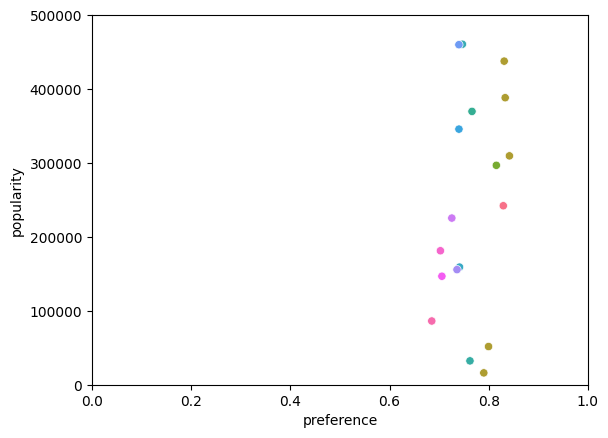

,artists,popularity,preference,country
0,Backstreet Boys,1413894.0,0.958230,United States
1,R. Kelly,1456472.0,0.954337,United States
2,Céline Dion,1376413.0,0.950273,Canada
3,Shania Twain,949638.0,0.906305,Canada
4,Westlife,625166.0,0.906134,Ireland
5,Savage Garden,916122.0,0.891713,Australia
6,Girls Aloud,723845.0,0.887001,United Kingdom
7,Jennifer Hudson,613389.0,0.868961,United States
8,McFly,528862.0,0.865171,United Kingdom
9,Aqua,736391.0,0.845394,Denmark


In [34]:
chosen_artists = [a for a in artists if x[a].X > .99]
chosen_countries = [c for c in artists_in_country if y[c].x > 0.99]
print("%i artists in %i countries chosen."%(len(chosen_artists),len(chosen_countries)))
print("Represented countries:",chosen_countries)

df_chosen_artists = pd.DataFrame({'artists':chosen_artists, 'popularity':[popularity[i] for i in chosen_artists], 'preference':[preference[i] for i in chosen_artists], 'country':[dict_artist_country[i] for i in chosen_artists]})
sns.scatterplot(data=df_chosen_artists, x="preference", y="popularity", hue="country", legend = False)
plt.xlim(0, 1)
plt.ylim(0, 500000)
plt.show()
df_chosen_artists 

We can definitely see more international diversity among the chosen set of artists.

While this notebook walked through how to build an optimization model piece-by-piece, the following code contains the overall optimization model. You can input different parameter values for  Pmax  (maximum limit on the average popularity),  N  (number of chosen artists ) and  Cmin  (minimum limit on the number of countries to be represented) and see how the optimal solution changes. The value of  Pmax  can be controlled using the slider below the cell.

What happens if  Pmax  is too low? Is there a trade-off between popularity and likeability? Can you find a solution where all the artists are uniquely different countries?

In [35]:
def solve(x):
    # Input parameters for artist selection
    P_max = x # maximumum limit on the average popularity
    N = 30 # number of chosen artists 
    C_min = 30 # minimum limit on the number of countries to be represented
    
    #Initiate the model 
    m = gp.Model("Playlisting")  
    
    # Define the variables
    x = m.addVars(artists,vtype=GRB.BINARY) 
    y = m.addVars(countries, vtype=GRB.BINARY) 
    
    # Define the objective 
    m.setObjective(sum(x[a]*preference[a] for a in artists), GRB.MAXIMIZE)
    m.ModelSense = GRB.MAXIMIZE
    
    # Add the constraitns 
    m.addConstr(sum(x[a]*popularity[a] for a in artists) <= P_max*N) # Sets a maximum limit on the average popularity
    m.addConstr(sum(x[a] for a in artists) == N) # Selects exactly N artists 
      
    m.addConstrs((y[c] <= sum(x[a] for a in artists_in_country[c])) for c in countries) # Selects a country only if an artist from that country is chosen
    m.addConstr(sum(y[c] for c in artists_in_country) >= C_min) # Sets a minimum limit on the number of countries represented
    
    m.setParam('OutputFlag', 0) # Suppress the output
    m.optimize() # Run the optimization of the model
    
    if m.status != 2:
        print("\n The problem is infeasible. There is no solution that satisfies all the constraints.")
        print("Try increasing the maximum popularity limit, or decreasing the minimum number of countries to be represented.")
        return
 
    chosen_artists = [a for a in artists if x[a].X > .99] # Chosen set of artists 
    chosen_countries = [c for c in artists_in_country if y[c].x > 0.99] # Chosen set of countries 
    print("%i artists in %i countries chosen."%(len(chosen_artists),len(chosen_countries)))
    print("Represented countries:",chosen_countries)

    # Create a dataframe for the visualization
    df_chosen_artists = pd.DataFrame({'artists':chosen_artists, 'popularity':[popularity[i] for i in chosen_artists], 'preference':[preference[i] for i in chosen_artists], 'country':[dict_artist_country[i] for i in chosen_artists]})
    sns.scatterplot(data=df_chosen_artists, x="preference", y="popularity", hue="country", legend = False)
    plt.xlim(0.6, 1)
    plt.ylim(0, 5000000)
    plt.show()
    print(df_chosen_artists)
     
print("Select a maximum limit on the average popularity:\n")
interact(solve, x=(200000,2000000,200000))

Select a maximum limit on the average popularity:



interactive(children=(IntSlider(value=1000000, description='x', max=2000000, min=200000, step=200000), Output(…

<function __main__.solve(x)>